In [155]:
import pandas as pd

# Fájl beolvasása fejléc nélkül
excel_path = "./Pontlebontas.xlsx"
adatbazis = pd.read_excel(excel_path, header=None)

In [ ]:
# Az első sor az oszlopnevek
column_names = adatbazis.iloc[0].tolist()

# A többi sor az adat
data = adatbazis.iloc[1:].copy()
data.columns = column_names

# Összevonás az ismétlődő oszlopnevek mentén
merged_data = pd.DataFrame()

for col in pd.unique(column_names):
    same_cols = data.loc[:, [c for c in data.columns if c == col]]
    # Cellaszintű összevonás: első nem -1 értéket megtartani
    merged_col = same_cols.apply(lambda row: next((x for x in row if x != -1), -1), axis=1)
    merged_data[col] = merged_col

# merged_data.reset_index(drop=True, inplace=True)
# merged_data.head()

In [123]:
# Új Excel-file elnevezése
output_path = "C:/Users/Tamás/Desktop/Gazdinfó/Gazdinfó-harmadév/MasodikFelev/MestIntelligencia/Pontlebontas_merged.xlsx"

# Új Excel-file mentése
merged_data.to_excel(output_path, index=False)

In [124]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)


# print(merged_data.dtypes)

columnTypes = merged_data.dtypes.value_counts()
columnTypes

int64      74
float64     1
object      1
Name: count, dtype: int64

FEATURE IMPORTANCE ANALÍZIS

In [159]:
# Csak a 2020 utáni adatokat vizsgáljuk
merged_data2020 = merged_data[merged_data['Év'] >= 2020].copy()

In [160]:
# Csak numerikus oszlopokat vizsgálunk
numeric_cols = merged_data2020.select_dtypes(include='number').columns.tolist()

# -1 értékek NaN-ná alakítása
for col in numeric_cols:
    merged_data2020.loc[merged_data2020[col] == -1, col] = pd.NA

# Csak azokat az oszlopokat tartjuk meg, ahol legalább 80% adat elérhető
threshold = 0.8
vizsgalandoOszlopok = [col for col in numeric_cols if merged_data2020[col].notna().mean() >= threshold]

# Feltöltjük a hiányzó értékeket az oszlopátlaggal
merged_data2020[vizsgalandoOszlopok] = merged_data2020[vizsgalandoOszlopok].fillna(merged_data2020[vizsgalandoOszlopok].mean())

In [162]:
# Jellemzők és célváltozó kiválasztása
X = merged_data2020[vizsgalandoOszlopok].drop(columns=['Helyezés', 'Pontszám', 'Év'], errors='ignore')
y = merged_data2020.loc[X.index, 'Helyezés']

In [163]:
# Eltávolítjuk a még mindig hiányos sorokat
X = X.dropna()
y = y.loc[X.index]

In [164]:
# Random Forest modell illesztése
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Feature importance kinyerése és rendezése
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

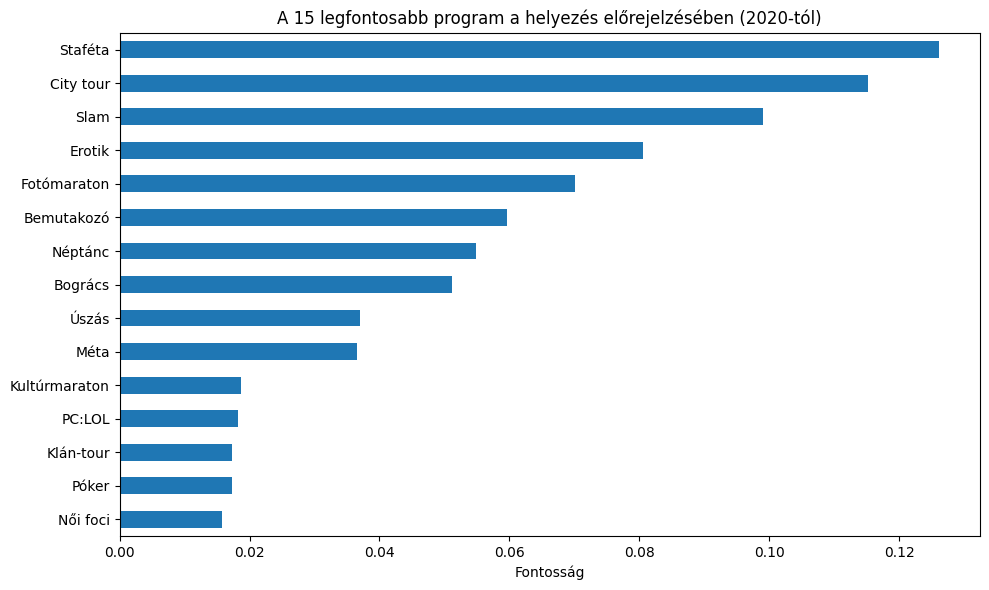

In [165]:
# Top 15 program megjelenítése
top_n = 15
plt.figure(figsize=(10, 6))
importances.head(top_n).plot(kind='barh')
plt.title(f'A {top_n} legfontosabb program a helyezés előrejelzésében (2020-tól)')
plt.xlabel('Fontosság')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [125]:
from sklearn.model_selection import train_test_split

# A Csapatokat számontartjuk (csak az ismétlődő csapatokat)
csapatSzamlalo = merged_data["Csapat"].value_counts()
ismetlodoCsapatok = csapatSzamlalo[csapatSzamlalo > 1].index.tolist()

In [126]:
# Csak az ismétlődő csapatokra szúrünk
merged_data_ismert = merged_data[merged_data["Csapat"].isin(ismetlodoCsapatok)].copy()

# Tanuló adatok és célváltozó meghatározása
X = merged_data_ismert.drop(columns = ["Helyezés", "Csapat", "Év"])
y = merged_data_ismert["Helyezés"]

# Tanuló- és teszt adathalmaz szétválasztása
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# LINEÁRIS REGRESSZIÓ ÉS RANDOM ERDŐ ALGORITMUSSAL VALÓ ELEMZÉS

In [127]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Modellpéldányok létrehozása
linreg = LinearRegression()
rfreg = RandomForestRegressor(random_state=42)

# Betanítás
linreg.fit(X_train, y_train)
rfreg.fit(X_train, y_train)

# Előrejelzés
y_pred_lin = linreg.predict(X_test)
y_pred_rf = rfreg.predict(X_test)

# Kiértékelés
def evaluate(y_true, y_pred, model_name):
    print(f"\n📊 {model_name} eredmények:")
    print(f"MAE (Átlagos abszolút hiba): {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"RMSE (Négyzetes középhiba): {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
    print(f"R² (magyarázott variancia): {r2_score(y_true, y_pred):.2f}")

evaluate(y_test, y_pred_lin, "Lineáris regresszió")
evaluate(y_test, y_pred_rf, "Random Forest regresszió")



📊 Lineáris regresszió eredmények:
MAE (Átlagos abszolút hiba): 10.17
RMSE (Négyzetes középhiba): 12.92
R² (magyarázott variancia): 0.34

📊 Random Forest regresszió eredmények:
MAE (Átlagos abszolút hiba): 4.08
RMSE (Négyzetes középhiba): 5.58
R² (magyarázott variancia): 0.88


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Szűrjük az adatokat 2020-tól, és aggregáljuk csapatonként
recent_data = merged_data[merged_data['Év'] >= 2020].copy()
aggregated_data = recent_data.groupby('Csapat').agg({
    col: 'mean' for col in recent_data.columns if col != 'Csapat'
}).reset_index()

# Mentsük el a csapatneveket az átalakítás előtt
team_names = aggregated_data['Csapat'].copy()

# Adat előkészítése modellezéshez
X = aggregated_data.drop(['Helyezés', 'Csapat', 'Év'], axis=1)  # Bemeneti változók
y = aggregated_data['Helyezés']  # Célváltozó

# Nem numerikus oszlopok kezelése, ha vannak
le = LabelEncoder()
for column in X.columns:
    if X[column].dtype == 'object':
        X[column] = le.fit_transform(X[column].astype(str))



# Random Forest modell létrehozása és betanítása az összes adaton
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Előrejelzések készítése minden csapatra
y_pred = rf_model.predict(X)

# Eredmény DataFrame létrehozása
results = pd.DataFrame({
    'Team': team_names,
    'Actual Helyezés': y.round(2),
    'Predicted Helyezés': y_pred.round(2),
    'Difference': abs(y - y_pred).round(2)
})

In [ ]:
# Két külön modell létrehozása – egyik helyezésre, másik pontszámra
rf_model_ranking = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_points = RandomForestRegressor(n_estimators=100, random_state=42)

# Bemeneti és célváltozók előkészítése
X = aggregated_data.drop(['Helyezés', 'Csapat', 'Év', 'Pontszám'], axis=1)  # Bemeneti változók
y_ranking = aggregated_data['Helyezés']  # Célváltozó a helyezéshez
y_points = aggregated_data['Pontszám']   # Célváltozó a pontszámhoz

In [ ]:
# Mindkét modell betanítása
rf_model_ranking.fit(X, y_ranking)
rf_model_points.fit(X, y_points)

# Előrejelzések készítése mindkét metrikára
y_pred_ranking = rf_model_ranking.predict(X)
y_pred_points = rf_model_points.predict(X)

In [ ]:
# Eredménytábla létrehozása mindkét előrejelzéssel
results = pd.DataFrame({
    'Team': team_names,
    # 'Actual Helyezés': y_ranking.round(2),
    'Predicted Helyezés': y_pred_ranking.round(2),
    # 'Actual Pontszám': y_points.round(2),
    'Predicted Pontszám': y_pred_points.round(2),
    # 'Helyezés Difference': abs(y_ranking - y_pred_ranking).round(2),
    # 'Pontszám Difference': abs(y_points - y_pred_points).round(2)
})

# Rendezzük az előrejelzett helyezés szerint és hozzunk létre rangsort
results = results.sort_values('Predicted Helyezés', ascending=True)
results['Predicted Rank'] = range(1, len(results) + 1)

In [ ]:
# Azon oszlopok, amelyeket meg is szeretnénk jeleníteni
final_results = results[['Team', 'Predicted Pontszám', 'Predicted Rank']].head(10)
print("Az előrejelzett első 10 csapat 2025-ben:")
print(final_results)

print("\nHelyezés modell teljesítménymutatói:")
print("================================")
print(f"Ranking Mean Squared Error: {mean_squared_error(y_ranking, y_pred_ranking):.2f}")
print(f"Ranking R² Score: {r2_score(y_ranking, y_pred_ranking):.2f}")

print("\nPontszám modell teljesítménymutatói:")
print("==============================")
print(f"Points Mean Squared Error: {mean_squared_error(y_points, y_pred_points):.2f}")
print(f"Points R² Score: {r2_score(y_points, y_pred_points):.2f}")

Az előrejelzett első 10 csapat 2025-ben:
            Team  Predicted Pontszám  Predicted Rank
50       S'tudja             5038.72               1
37    Kóma Sutra             4639.93               2
2       FuckTúra             4626.63               3
32     GenItália             4637.84               4
7       UNI-GUNS             4644.11               5
52    Shakesbeer             4512.42               6
0      Beez-Mute             4382.67               7
63     Vá$örhely             4404.67               8
1    Búvármedvék             4186.82               9
22      CheekLow             4163.83              10

Ranking Model Performance Metrics:
Ranking Mean Squared Error: 15.11
Ranking R² Score: 0.94

Points Model Performance Metrics:
Points Mean Squared Error: 28565.55
Points R² Score: 0.94


UNSUPERVISED LEARNING ALGORITMUS

In [135]:
# Kiszűrni azokat az oszlopokat, amelyekben alig van hasnzálható információ (az érték -1)

negativOszlopokSzama = (merged_data == -1).sum().sort_values(ascending=False)
negativOszlopok = negativOszlopokSzama[negativOszlopokSzama > 0.90 * len(merged_data)].index

# Ezeknek az oszlopoknak az eltávolítása
tisztitottMergedData = merged_data.drop(columns = negativOszlopok)

In [136]:
# Az adatokat csak 2020-tól vizsgáljuk

tisztitottMergedData2020 = tisztitottMergedData.copy()
tisztitottMergedData2020 = tisztitottMergedData2020[tisztitottMergedData2020['Év'] >= 2020].copy()

In [137]:
# Csapatok különböző kategóriákba sorolása cluster-ezéssel

sportok = ['Férfi foci', 'Női foci', 'Kosárlabda', 'Kézilabda', 'Strandröplabda', 'Tenisz', 'Sakk', 'Úszás', 'Lábtenisz', 'Bowling', 'Íjászat', 'Biciklitúra', 'Asztalitenisz', 'Staféta', 'Méta', 'Röpi']
kocsmasportok = ['Beer-Pong', 'Póker', 'Krucsa', 'Bolc', 'Bolc', 'PC:LOL', 'Csocsó', 'Táblé', 'Biliárd', 'Dártsz', 'PC:CS 2', 'Chest-Pong', 'Chandelier', 'Jenga']
kozossegi = ['Erotik', 'Paintball', 'Piramis', 'Bogrács', 'Bónusz feladat', 'Klán-tour', 'Klán-Tour 2', 'Klán-tour night']
kultura = ['Néptánc', 'Táncmaraton', 'Kultúrmaraton', 'Karaoké', 'Fotómaraton', 'Cooltúra', 'Dance battle']

# Ellenőrizzük, hogy minden oszlop megtalálható-e a DataFrame-ben
kategoriak = sportok + kocsmasportok + kozossegi + kultura
kategoriak = [col for col in kategoriak if col not in tisztitottMergedData2020.columns]

In [138]:
# -1 értékek NaN-ná alakítása
tisztitottMergedData2020[kategoriak] = tisztitottMergedData2020[kategoriak].replace(-1, np.nan)

In [139]:
# Kategóriaátlagok kiszámítása 
tisztitottMergedData2020['Sport_Átlag'] = tisztitottMergedData2020[
[col for col in sportok if col in tisztitottMergedData2020.columns]
].mean(axis=1)

tisztitottMergedData2020['Kocsmasport_Átlag'] = tisztitottMergedData2020[
    [col for col in kocsmasportok if col in tisztitottMergedData2020.columns]
].mean(axis=1)

tisztitottMergedData2020['Kozossegi_Átlag'] = tisztitottMergedData2020[
    [col for col in kozossegi if col in tisztitottMergedData2020.columns]
].mean(axis=1)

tisztitottMergedData2020['Kultura_Átlag'] = tisztitottMergedData2020[
    [col for col in kultura if col in tisztitottMergedData2020.columns]
].mean(axis=1)

In [140]:
# Adatkiválasztás klaszterezéshez
clusterAdatok = tisztitottMergedData2020[['Sport_Átlag', 'Kocsmasport_Átlag', 'Kozossegi_Átlag', 'Kultura_Átlag']].dropna(how='all')

In [141]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [142]:
# Standardizálás
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clusterAdatok   )

# KMeans klaszterezés
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Klaszter hozzáadása
tisztitottMergedData2020_clustered = tisztitottMergedData2020.loc[clusterAdatok.index].copy()
tisztitottMergedData2020_clustered['Klaszter'] = clusters

In [143]:
# Domináns klaszter meghatározása csapatonként
dominancia = tisztitottMergedData2020_clustered.groupby('Csapat')['Klaszter'].agg(lambda x: x.mode().iloc[0]).reset_index()


In [151]:
# Klasztercímkék hozzárendelése
clusterCimkek = {
    0: 'Közösségi',
    1: 'Kocsmasport',
    2: 'Sport',
    3: 'Kultúra'
}

dominancia['Kategória'] = dominancia['Klaszter'].map(clusterCimkek)
print(dominancia[['Csapat', 'Kategória']])

              Csapat    Kategória
0          Beez-Mute      Kultúra
1        Búvármedvék      Kultúra
2           FuckTúra  Kocsmasport
3             IGNORE  Kocsmasport
4             InTeam      Kultúra
..               ...          ...
70          beerLUCK      Kultúra
71  diaknapos csapat    Közösségi
72         ginSTABIL  Kocsmasport
73       proDUCKtive  Kocsmasport
74           ‘cuzGáz  Kocsmasport

[75 rows x 2 columns]


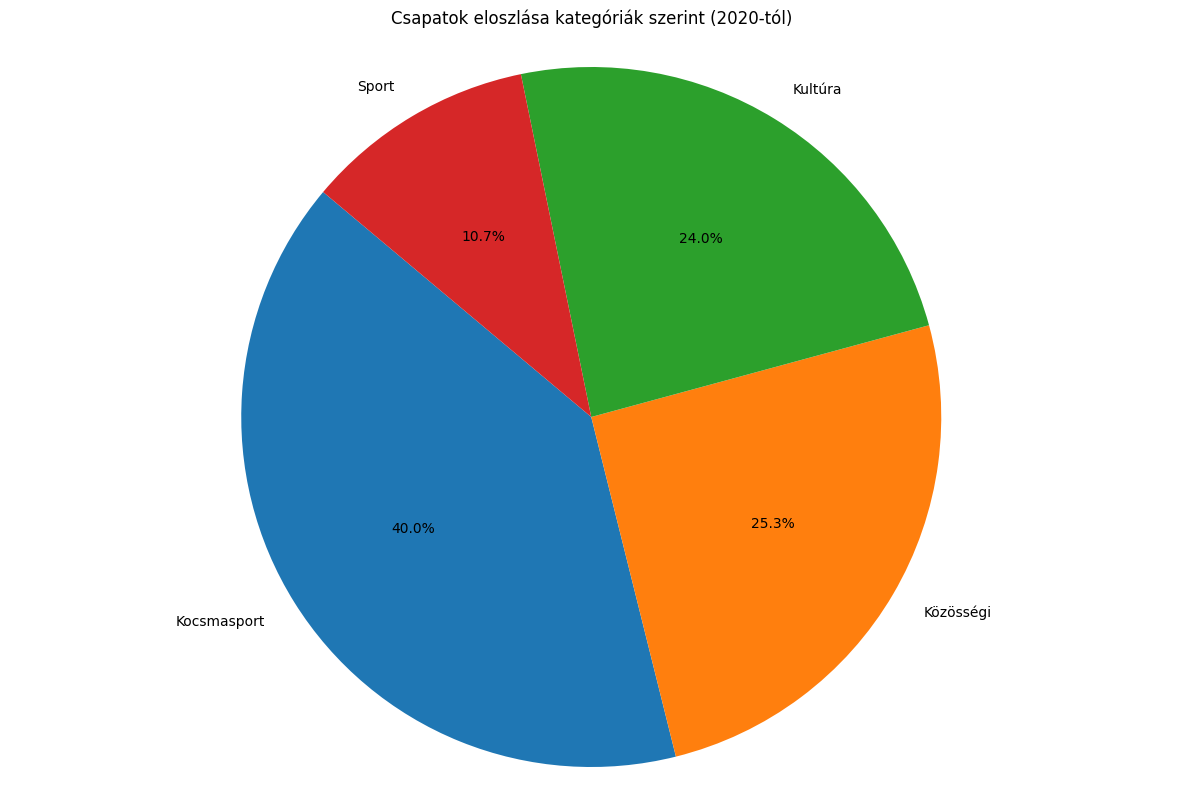

In [152]:
import matplotlib.pyplot as plt

# Kategóriák gyakorisága
kategoriakSzazalekban = dominancia['Kategória'].value_counts(normalize = True) * 100

# Oszlopdiagram készítése
plt.figure(figsize=(15, 10))
# kategoriakGyakorisaga.plot(kind='bar', color='skyblue')
plt.pie(kategoriakSzazalekban, labels = kategoriakSzazalekban.index, autopct = '%1.1f%%', startangle = 140)
plt.title('Csapatok eloszlása kategóriák szerint (2020-tól)')
plt.axis('equal')
plt.show()

A Diáknapok eseményeinek történelmi adatai alapján felügyelt és felügyelet nélküli tanulási algoritmusokat alkalmaztunk annak érdekében, hogy átlássuk a csapatok viselkedésmintázatait, előre jelezzük a 2025-ös verseny várható kimenetelét. A felügyelt gépi tanulás esetében két fajta módszert próbáltunk ki, a lineáris regressziót és a véletlenszerű erdőt. Azért ezeket, mert az adatbázisnak a szerkezete, hogy rendezett, könnyen meg lehet határozni a célváltozót és a magyarázó változókat, lehetővé teszi, hogy a korábban említett módszerekkel könnyedén tudjuk elemezni az adatokat. 

Az eredmények prediktálása előtt meg lett vizsgálva (feature importance elemzést használva), hogy az előző évek alapján melyek azok a programok, amelyek leginkább befolyásolhatják a csapatok helyezéseit. Ezek alapján a számos program közül a következő 10 befolyásolja leginkább egy csapatnak a helyezését: staféta, city tour, slam, erotik, fotómaraton, bemutatkozó, néptánc, bogrács, úszás, méta.

Az elemzés során több változót is vizsgáltunk, legfőképpen az R² (R² score)-t, amely azt mutatja meg, hogy az előrejelzett értékek mennyiben egyeznek meg a valós értékekkel. Ez egy 0 és 1 közötti változó, minél közelebb van 1-hez, annál jobb. Esetünkben ez az érték lineáris regresszió esetén 0.34 ami kifejezetten gyenge eredmény, viszont a véletlenszerű erdő algoritmusa 0.88-as eredményt adott ki, ami nagyon pontos modellnek számít, szóval ezzel mentünk tovább. Az elemzés végén pedig a modell azt jósolja, hogy a 2025-ös diáknapokon az első 5-ben a következő lesz a sorrend: S'tudja, Kóma Sutra, FuckTúra, GenItália, UNI-GUNS.

A felügyeletlen gépi tanulási módszer esetén egy klaszterezést végeztem el vizsgálva azt, hogy a csapatok az évek során szerzett pontok alapján a programok alatt milyen "kategóriákba" sorollhatóak be. Létre lett hozva 4 kategória: sportok, kocsmasportok, kultúrális és közösségi programok. Ahogy a klaszterezés után megjelenített ábrán is látszik, hogy az elmúlt évek alapján a legtöbb csapat (40%-ban) leginkább a kocsmasportokban jeleskedik, utána pedig a közösségi programokban a legaktívabbak.